# Assessing entanglement detection methods

1. First, we show that all 3 methods report the same qubits as the least entangled.
2. Second, these methods report equivalent decompositions (TODO).
2. Third, we assess memory and time consumption methods.

## Helper functions

In [1]:
!pip install psutil

In [2]:
import numpy as np
import time
import psutil
import tensorly as tl
import gc

from ncon import ncon
from tqdm import tqdm
from tensorly import decomposition
from qiskit import transpile, QuantumCircuit, quantum_info
from qiskit.providers.aer.backends import AerSimulator
from qiskit.quantum_info import Statevector
from qclib.state_preparation import LowRankInitialize, BaaLowRankInitialize

backend = AerSimulator()


def to_state(vector):
    return vector / sum(abs(vector) ** 2) ** .5


def to_tensor(vector):
    n = int(np.log2(vector.size))
    return vector.reshape([2] * n)


def get_real_svec(ndim):
    return to_state(np.array(np.random.random(2 ** ndim)))


def get_compex_svec(ndim):
    amp = get_real_svec(ndim)
    pha = get_real_svec(ndim) * np.pi * 2
    return to_state(np.array([a * np.e ** (1j * p) for a, p in zip(amp, pha)]))


def shuffle_tensor(vec):
    res = to_tensor(vec)
    shuf = list(range(res.ndim))
    np.random.shuffle(shuf)
    return tl.moveaxis(res, range(res.ndim), shuf)


def some_noise(tensor, amplitude=0.0001):
    shape = tensor.shape
    noise = (np.random.random(tensor.size) - 0.5) * amplitude * 2
    return (tensor.reshape(-1) + noise).reshape(shape)


def prepare_bipartite_tensor(i, j, noise_amplitude=0.000001):
    return some_noise(shuffle_tensor(np.kron(get_compex_svec(i), get_compex_svec(j))), noise_amplitude)


def get_mem():
    import resource
    # return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
    return psutil.Process().memory_info().rss

In [3]:
get_mem()

132104192

In [4]:
def recombine(state_one, state_other, position):
    tensor = np.tensordot(state_one, state_other, 0)
    target = list(range(1, position+1)) + [0] + list(range(position+1, tensor.ndim))
    return tl.moveaxis(tensor, range(tensor.ndim), target)
    
a = get_compex_svec(2).reshape(2, 2)
b = get_compex_svec(1).reshape(2)
recombine(b, a, 1)

array([[[ 0.13926835+0.34193901j, -0.25304515+0.46045095j],
        [ 0.16337376+0.01021285j,  0.13517291+0.18970857j]],

       [[ 0.03235555+0.48150941j, -0.32202707+0.29455282j],
        [ 0.19853056+0.07978194j,  0.05563697+0.18531803j]]])

We will assess 3 methods. `single_split` from `qclib`, and two our methods: counting based and contraction-based. For each method we will assess the following things:
- Equal detection of disentangled qubit.
- CPU time and memory to find disentangled qubit.
- CPU time to prepare the partition states.

# Iterative SVD

    # We need to swap qubits from their subsystem2 position to the end of the
    # mode as we expect that we do LSB to be on the left-most side.

ok, they use `np.moveaxis`, `np.reshape`, and `np.linalg.svd` for this: [code](https://github.com/qclib/qclib/blob/18313110165daf94308b7d417a517e0b4a12117f/qclib/entanglement.py#L143).

    # Maintains the relative position between the qubits of the two subsystems.
 
Ok, here [code](https://github.com/qclib/qclib/blob/18313110165daf94308b7d417a517e0b4a12117f/qclib/state_preparation/util/baa.py#L290).

In [5]:
def test_svd(nqubits, seed, returnStates=False):
    np.random.seed(seed)
    T = prepare_bipartite_tensor(nqubits - 1, 1)
    # gc.collect()
    min_mem = get_mem()
    max_mem = min_mem
    
    result = []
    
    start = time.time()
    for i in range(T.ndim):
        victim = np.moveaxis(T, i, -1).reshape(-1, 2)
        u, s, v = np.linalg.svd(victim)
        result.append(s[1])
        max_mem = max(max_mem, get_mem())
    searchtime = time.time() - start
    
    minqubit = np.argmin(result)
    
    partitions = np.moveaxis(T, minqubit, 0).reshape(2, -1)
    max_mem = max(max_mem, get_mem())
    u, s, v = np.linalg.svd(victim)
    start = time.time()
    state1 = to_state(u[:, 0])
    state2 = to_state(v[0, :].T)
    separatetime = time.time() - start
    max_mem = max(max_mem, get_mem())

    return {
        "search_time": searchtime,
        "separate_time": separatetime,
        "entanglement": result,
        "min_qubit": minqubit,
        "state1": state1 if returnStates else None,
        "state2": state2 if returnStates else None,
        "memory": max_mem - min_mem,
        "state0": T.reshape(-1) if returnStates else None
    }


print(test_svd(13, seed=12))

{'search_time': 3.4271140098571777, 'separate_time': 0.0007429122924804688, 'entanglement': [0.3550931279460915, 0.3558071177988411, 3.702554736519266e-05, 0.34902328673523764, 0.35131678944017425, 0.3496355822286039, 0.3586838224314115, 0.35791927182816474, 0.3569548534114317, 0.3564265911195804, 0.35236780062296547, 0.3538147432316693, 0.3568097249579846], 'min_qubit': 2, 'state1': None, 'state2': None, 'memory': 269721600, 'state0': None}


# Tucker + reduction

In [6]:
def test_ncon(nqubits, seed, returnStates=False):
    np.random.seed(seed)
    T = prepare_bipartite_tensor(nqubits - 1, 1)
    # gc.collect()
    min_mem = get_mem()
    max_mem = min_mem

    result = []
    
    start = time.time()
    
    c, m = decomposition.tucker(T, rank=T.shape)
    max_mem = max(max_mem, get_mem())

    cabs = abs(c)
    plus = np.array([1, 1]) * .5 ** .5
    one = np.array([0, 1])

    contractions = []
    # outgoing contractions of core tensor
    contractions.append(list(range(1, T.ndim + 1)))
    # measurements
    contractions += [[q] for q in contractions[0]]


    for i in range(T.ndim):
        # for each mode i we will replace m[i] with I tensor
        # while for the others we will contract to |+>
        measurements = [plus] * T.ndim
        measurements[i] = one        
        tensors = [cabs] + measurements
        # hang a free leg
        result.append(ncon(tensors, contractions))
        max_mem = max(max_mem, get_mem())


    searchtime = time.time() - start
    
    minqubit = np.argmin(result)
        
    start = time.time()
    state1 = to_state(m[minqubit][:, 0].reshape(-1))
    contractions = []
    contractions.append(list(range(1, T.ndim + 1)))
    contractions += [[q, -q] for q in contractions[0]]    
    m[minqubit] = state1
    contractions[minqubit + 1] = [minqubit + 1]
    state2 = to_state(ncon([c] + m, contractions).reshape(-1))
    separatetime = time.time() - start
    max_mem = max(max_mem, get_mem())
    
    return {
        "search_time": searchtime,
        "separate_time": separatetime,
        "entanglement": result,
        "min_qubit": minqubit,
        "state1": state1 if returnStates else None,
        "state2": state2 if returnStates else None,
        "memory": max_mem - min_mem,
        "state0": T.reshape(-1) if returnStates else None
    }


print(test_ncon(16, seed=12))

{'search_time': 0.833388090133667, 'separate_time': 0.0061609745025634766, 'entanglement': [array(0.20172854), array(0.19922641), array(0.1994618), array(0.19980421), array(0.20072013), array(8.74485915e-05), array(0.201299), array(0.19912068), array(0.20110123), array(0.19940567), array(0.19945356), array(0.20182796), array(0.19972769), array(0.19914872), array(0.19987024), array(0.20023147)], 'min_qubit': 5, 'state1': None, 'state2': None, 'memory': 33488896, 'state0': None}


# Tucker + count

In [7]:
def get_singular_sum(core):
    import itertools
    from collections import Counter
    result = np.zeros((core.ndim,))
    for index in itertools.product([0, 1], repeat=core.ndim):
        for i, v in enumerate(index):
            if v == 1: 
                result[i] += abs(core[index]) ** 2
    return result.tolist()


def test_counting(nqubits, seed, returnStates=False):
    np.random.seed(seed)
    T = prepare_bipartite_tensor(nqubits - 1, 1)
    # gc.collect()
    min_mem = get_mem()
    max_mem = min_mem

    result = []
    
    start = time.time()
    c, m = decomposition.tucker(T, rank=T.shape)
    result = get_singular_sum(c)
    searchtime = time.time() - start
    max_mem = max(max_mem, get_mem())
    
    minqubit = np.argmin(result)
        
    start = time.time()
    state1 = to_state(m[minqubit][:, 0].reshape(-1))
    contractions = []
    contractions.append(list(range(1, T.ndim + 1)))
    contractions += [[q, -q] for q in contractions[0]]
    m[minqubit] = state1
    contractions[minqubit + 1] = [minqubit + 1]
    state2 = to_state(ncon([c] + m, contractions).reshape(-1))
    separatetime = time.time() - start
    max_mem = max(max_mem, get_mem())
    
    return {
        "search_time": searchtime,
        "separate_time": separatetime,
        "entanglement": result,
        "min_qubit": minqubit,
        "state1": state1 if returnStates else None,
        "state2": state2 if returnStates else None,
        "memory": max_mem - min_mem,
        "state0": T.reshape(-1) if returnStates else None
    }


print(test_counting(13, seed=12))

{'search_time': 0.16744613647460938, 'separate_time': 0.0012660026550292969, 'entanglement': [0.1260911295145393, 0.12659870507631868, 1.3708911576921328e-09, 0.12181725468346796, 0.123423486542552, 0.12224504036033522, 0.12865408447400856, 0.12810620514600368, 0.1274167673739769, 0.12703991485712493, 0.1241630669158665, 0.12518487252809224, 0.12731317982459261], 'min_qubit': 2, 'state1': None, 'state2': None, 'memory': 1552384, 'state0': None}


## Correctness validation

In [8]:
sizes = [7, 10]
attempts = 10

for size in sizes:
    for attempt in range(attempts):
        print()
        r = test_svd(size, seed=attempt, returnStates=True)
        print("SVD")
        print(f"Qubit = {r['min_qubit']}")
        # s0 = to_tensor(r['state0'])
        # s1 = to_tensor(r['state1'])
        # s2 = to_tensor(r['state2'])
        # s = recombine(s1, s2, r['min_qubit']).reshape(-1)        
        # print(f"Fidelity = {quantum_info.state_fidelity(to_state(s), to_state(r['state0']))}")

        r = test_ncon(size, seed=attempt, returnStates=True)
        print("NCON")
        print(f"Qubit = {r['min_qubit']}")
        # s0 = to_tensor(r['state0'])
        # s1 = to_tensor(r['state1'])
        # s2 = to_tensor(r['state2'])
        # s = recombine(s1, s2, r['min_qubit']).reshape(-1)        
        # print(f"Fidelity = {quantum_info.state_fidelity(to_state(s), to_state(r['state0']))}")

        
        r = test_counting(size, seed=attempt, returnStates=True)
        print("Count")
        print(f"Qubit = {r['min_qubit']}")
        # s0 = to_tensor(r['state0'])
        # s1 = to_tensor(r['state1'])
        # s2 = to_tensor(r['state2'])
        # s = recombine(s1, s2, r['min_qubit']).reshape(-1)        
        # print(f"Fidelity = {quantum_info.state_fidelity(to_state(s), to_state(r['state0']))}")



SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6

SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6

SVD
Qubit = 3
NCON
Qubit = 3
Count
Qubit = 3

SVD
Qubit = 4
NCON
Qubit = 4
Count
Qubit = 4

SVD
Qubit = 1
NCON
Qubit = 1
Count
Qubit = 1

SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6

SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6

SVD
Qubit = 1
NCON
Qubit = 1
Count
Qubit = 1

SVD
Qubit = 3
NCON
Qubit = 3
Count
Qubit = 3

SVD
Qubit = 2
NCON
Qubit = 2
Count
Qubit = 2

SVD
Qubit = 9
NCON
Qubit = 9
Count
Qubit = 9

SVD
Qubit = 0
NCON
Qubit = 0
Count
Qubit = 0

SVD
Qubit = 4
NCON
Qubit = 4
Count
Qubit = 4

SVD
Qubit = 8
NCON
Qubit = 8
Count
Qubit = 8

SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6

SVD
Qubit = 4
NCON
Qubit = 4
Count
Qubit = 4

SVD
Qubit = 7
NCON
Qubit = 7
Count
Qubit = 7

SVD
Qubit = 8
NCON
Qubit = 8
Count
Qubit = 8

SVD
Qubit = 7
NCON
Qubit = 7
Count
Qubit = 7

SVD
Qubit = 6
NCON
Qubit = 6
Count
Qubit = 6


In [9]:
sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
attempts = 25

In [11]:
svd_results = {}

for i in sizes:
    lattempts = attempts
    if i == 15: lattempts = 10
    if i > 15: continue
        
    svd_results[i] = []
    print(f"Size {i}")
    for attempt in tqdm(range(lattempts)):
        svd_results[i].append(test_svd(nqubits=i, seed=attempt))

Size 2


100%|██████████| 25/25 [00:00<00:00, 1888.34it/s]


Size 3


100%|██████████| 25/25 [00:00<00:00, 1752.04it/s]


Size 4


100%|██████████| 25/25 [00:00<00:00, 1463.80it/s]


Size 5


100%|██████████| 25/25 [00:00<00:00, 1639.55it/s]


Size 6


100%|██████████| 25/25 [00:00<00:00, 1282.38it/s]


Size 7


100%|██████████| 25/25 [00:00<00:00, 803.11it/s]


Size 8


100%|██████████| 25/25 [00:00<00:00, 182.45it/s]


Size 9


100%|██████████| 25/25 [00:00<00:00, 70.34it/s]


Size 10


100%|██████████| 25/25 [00:01<00:00, 19.58it/s]


Size 11


100%|██████████| 25/25 [00:04<00:00,  5.22it/s]


Size 12


100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


Size 13


100%|██████████| 25/25 [01:33<00:00,  3.73s/it]


Size 14


100%|██████████| 25/25 [05:53<00:00, 14.12s/it]


Size 15


100%|██████████| 10/10 [25:29<00:00, 152.97s/it]


In [12]:
contraction_results = {}

for i in sizes:
    contraction_results[i] = []
    print(f"Size {i}")
    for attempt in tqdm(range(attempts)):
        contraction_results[i].append(test_ncon(nqubits=i, seed=attempt))

Size 2


100%|██████████| 25/25 [00:00<00:00, 560.65it/s]


Size 3


100%|██████████| 25/25 [00:00<00:00, 491.10it/s]


Size 4


100%|██████████| 25/25 [00:00<00:00, 380.36it/s]


Size 5


100%|██████████| 25/25 [00:00<00:00, 268.91it/s]


Size 6


100%|██████████| 25/25 [00:00<00:00, 188.16it/s]


Size 7


100%|██████████| 25/25 [00:00<00:00, 129.55it/s]


Size 8


100%|██████████| 25/25 [00:00<00:00, 84.91it/s]


Size 9


100%|██████████| 25/25 [00:00<00:00, 53.81it/s]


Size 10


100%|██████████| 25/25 [00:00<00:00, 37.16it/s]


Size 11


100%|██████████| 25/25 [00:01<00:00, 22.12it/s]


Size 12


100%|██████████| 25/25 [00:01<00:00, 13.04it/s]


Size 13


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Size 14


100%|██████████| 25/25 [00:06<00:00,  3.69it/s]


Size 15


100%|██████████| 25/25 [05:14<00:00, 12.57s/it]


Size 16


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Size 17


100%|██████████| 25/25 [00:50<00:00,  2.01s/it]


Size 18


100%|██████████| 25/25 [01:42<00:00,  4.09s/it]


Size 19


100%|██████████| 25/25 [03:42<00:00,  8.92s/it]


Size 20


100%|██████████| 25/25 [08:32<00:00, 20.49s/it]


In [13]:
counting_results = {}

for i in sizes:
    counting_results[i] = []
    print(f"Size {i}")
    for attempt in tqdm(range(attempts)):
        counting_results[i].append(test_ncon(nqubits=i, seed=attempt))

Size 2


100%|██████████| 25/25 [00:00<00:00, 597.32it/s]


Size 3


100%|██████████| 25/25 [00:00<00:00, 396.90it/s]


Size 4


100%|██████████| 25/25 [00:00<00:00, 312.49it/s]


Size 5


100%|██████████| 25/25 [00:00<00:00, 258.37it/s]


Size 6


100%|██████████| 25/25 [00:00<00:00, 183.83it/s]


Size 7


100%|██████████| 25/25 [00:00<00:00, 117.22it/s]


Size 8


100%|██████████| 25/25 [00:00<00:00, 78.40it/s]


Size 9


100%|██████████| 25/25 [00:00<00:00, 53.20it/s]


Size 10


100%|██████████| 25/25 [00:00<00:00, 31.61it/s]


Size 11


100%|██████████| 25/25 [00:01<00:00, 21.31it/s]


Size 12


100%|██████████| 25/25 [00:02<00:00, 12.28it/s]


Size 13


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Size 14


100%|██████████| 25/25 [00:07<00:00,  3.46it/s]


Size 15


100%|██████████| 25/25 [00:13<00:00,  1.84it/s]


Size 16


100%|██████████| 25/25 [00:27<00:00,  1.10s/it]


Size 17


100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


Size 18


100%|██████████| 25/25 [01:49<00:00,  4.39s/it]


Size 19


100%|██████████| 25/25 [08:53<00:00, 21.32s/it]


Size 20


100%|██████████| 25/25 [07:54<00:00, 18.97s/it]


In [14]:
import pickle

with open("dump.pkl", 'wb') as f:
    pickle.dump({"svd" : svd_results, "contraction": contraction_results, "counting": counting_results}, f)

## Search time

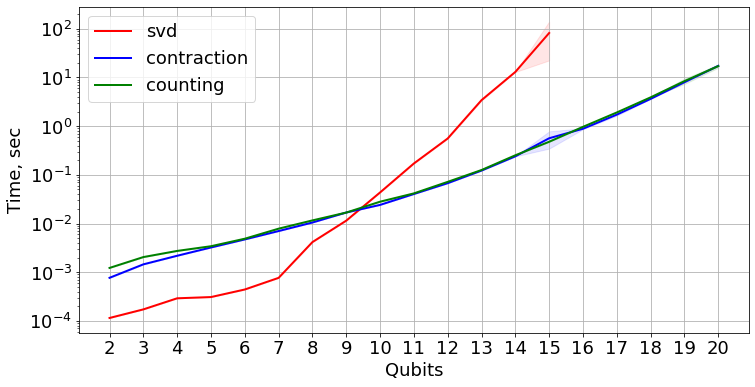

In [22]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 18


graphs = {"svd" : svd_results, "contraction": contraction_results, "counting": counting_results}
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 6))

for g, graph in enumerate(graphs):
    low, c, high = [], [], []

    for i in sizes:
        if i not in graphs[graph]: continue
        times = [x['search_time'] for x in graphs[graph][i]]
        avg = (sum(times) - min(times) - max(times)) / (len(times) - 2)
        std = (
                sum([(t - avg) ** 2 for t in times])
                    - (max(times) - avg) ** 2 
                    - (min(times) - avg) ** 2
                ) / (len(times) - 2) ** .5
        c.append(avg)
        low.append(avg - std)
        high.append(avg + std)
    plt.plot(sizes[:len(c)], c, color=colors[g], label=graph, lw=2)
    plt.fill_between(sizes[:len(c)], low, high, color=colors[g], alpha=.1)


plt.xlabel("Qubits")
plt.ylabel("Time, sec")
plt.xticks(sizes[:len(c)])
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## Decomposition time

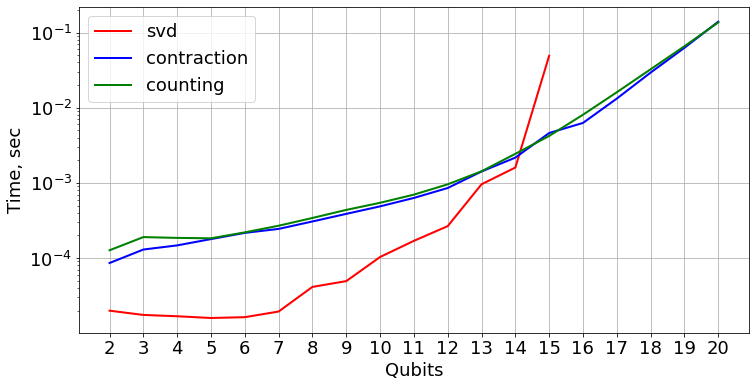

In [24]:
graphs = {"svd" : svd_results, "contraction": contraction_results, "counting": counting_results}
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 6))

for g, graph in enumerate(graphs):
    low, c, high = [], [], []

    for i in sizes:
        if i not in graphs[graph]: continue
        times = [x['separate_time'] for x in graphs[graph][i]]
        avg = (sum(times) - min(times) - max(times)) / (len(times) - 2)
        std = (
                sum([(t - avg) ** 2 for t in times])
                    - (max(times) - avg) ** 2 
                    - (min(times) - avg) ** 2
                ) / (len(times) - 2) ** .5        
        c.append(avg)
        low.append(avg - std)
        high.append(avg + std)

    plt.plot(sizes[:len(c)], c, color=colors[g], label=graph, lw=2)
    plt.fill_between(sizes[:len(c)], low, high, color=colors[g], alpha=.1)

plt.xlabel("Qubits")
plt.ylabel("Time, sec")
plt.xticks(sizes[:len(c)])
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## Total time

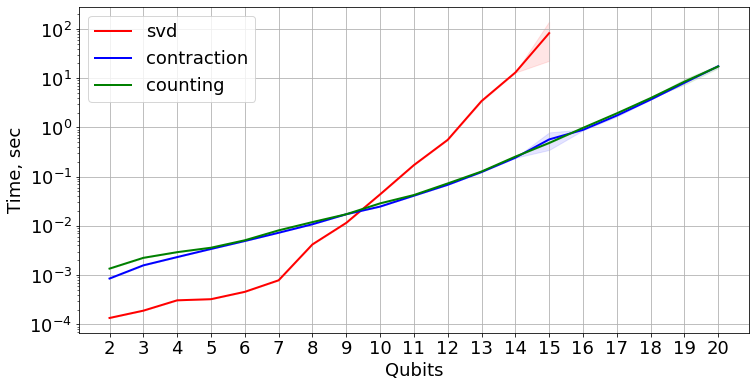

In [25]:
graphs = {"svd" : svd_results, "contraction": contraction_results, "counting": counting_results}
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 6))

for g, graph in enumerate(graphs):
    low, c, high = [], [], []

    for i in sizes:
        if i not in graphs[graph]: continue
        
        times = [x['separate_time'] + x['search_time'] for x in graphs[graph][i]]
        avg = (sum(times) - min(times) - max(times)) / (len(times) - 2)
        std = (
                sum([(t - avg) ** 2 for t in times])
                    - (max(times) - avg) ** 2 
                    - (min(times) - avg) ** 2
                ) / (len(times) - 2) ** .5
        c.append(avg)
        low.append(avg - std)
        high.append(avg + std)

    plt.plot(sizes[:len(c)], c, color=colors[g], label=graph, lw=2)
    plt.fill_between(sizes[:len(c)], low, high, color=colors[g], alpha=.1)


plt.xlabel("Qubits")
plt.ylabel("Time, sec")
plt.xticks(sizes[:len(c)])
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

## Memory

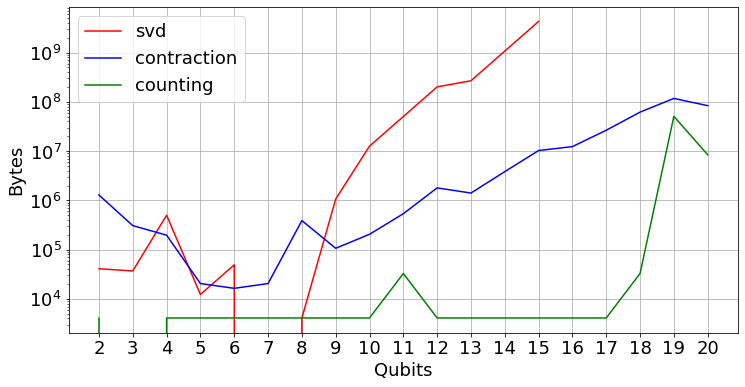

In [30]:
import matplotlib.pyplot as plt

graphs = {"svd" : svd_results, "contraction": contraction_results, "counting": counting_results}
colors = ['red', 'blue', 'green']

plt.figure(figsize=(12, 6))

for g, graph in enumerate(graphs):
    low, c, high = [], [], []
    for i in sizes:
        if i not in graphs[graph]: continue
        mems = [f['memory'] for f in graphs[graph][i]]
        avg = max(mems + [0])
        # std = sum([(m - avg) ** 2 for m in mems]) ** .5
        c.append(avg)
        # low.append(avg - std)
        # high.append(avg + std)

    plt.plot(sizes[:len(c)], c, color=colors[g], label=graph)
    # plt.fill_between(sizes[:len(c)], low, high, color=colors[g], alpha=.1)

plt.xlabel("Qubits")
plt.ylabel("Bytes")
plt.xticks(sizes[:len(c)])

plt.yscale('log')
plt.grid()
plt.legend()
plt.show()